再version 6的基础上，batchsize = 32， stem第一层变为4，用leaky relu，将inception a的函数里面的分支第一层神经元改为8

In [1]:
# import zipfile

# f = zipfile.ZipFile("/root/Breast Cancer/Datasets Backup/40X.zip",'r') # 压缩文件在jupyter中的位置
# for file in f.namelist():
#     f.extract(file,"/root/Breast Cancer/Datasets")               # 解压到的位置
# f.close()

In [2]:
# !pip install scipy

In [3]:
# !pip install tensorflow-addons==0.18.0
# !pip install scikit-learn
# !pip install seaborn


In [4]:
# from tensorflow_addons.metrics import F1Score

In [5]:
# pip install numba


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Concatenate, DepthwiseConv2D, Multiply,
    Dropout, GlobalAveragePooling2D, Dense, MaxPooling2D, Flatten, Add, Reshape, AveragePooling2D
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
# Any additional code or custom layers you have can be added here.


2024-03-09 20:39:57.742480: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
input_shape = (224, 224, 3)

test_dir = '/root/Breast Cancer/Datasets/40XResized/test'
train_dir = '/root/Breast Cancer/Datasets/40XResized/train'


batch_size = 32
num_classes = 2
# filter_factor = 8

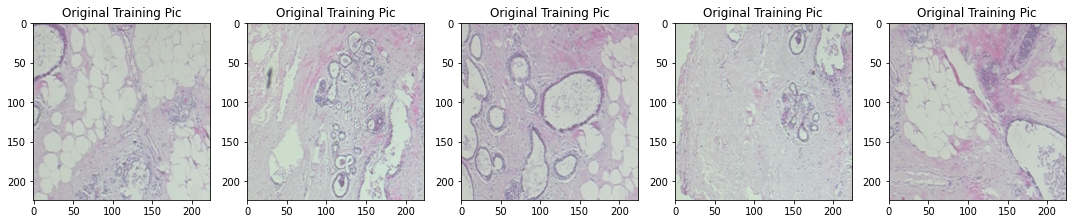

In [8]:
train_BC = '/root/Breast Cancer/Datasets/40XResized/train/benign'

#Show the import original image
train_img_files = os.listdir(train_BC)
# test_img_files = os.listdir(test_dir)
# val_img_files = os.listdir(val_dir)

show_num = 5

plt.figure(figsize = (15, 5))

for i in range(show_num):
    
    img_path = os.path.join(train_BC, train_img_files[i])
    img = plt.imread(img_path)
    plt.subplot(1, show_num, i + 1)
    plt.imshow(img)
    plt.axis('on')
    plt.title("Original Training Pic")
    
plt.tight_layout()
plt.show()


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.13,  # Specify the validation split here
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 'validation' subset for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2263 images belonging to 2 classes.
Found 338 images belonging to 2 classes.
Found 301 images belonging to 2 classes.


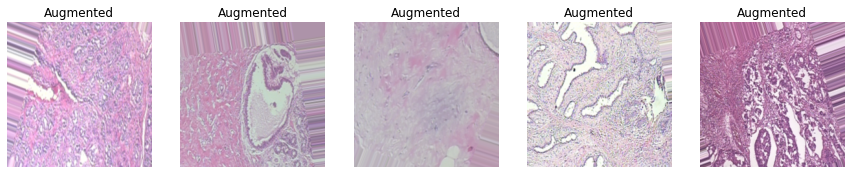

In [10]:
#To show the augmented pictures, after rotation, zoom in, rescale etc

# import scipy

# Extract a batch of images from the train_generator
sample_images, sample_labels = next(train_generator)

plt.figure(figsize = (15, 5))

# Show the original images from the batch
num_images_to_show = 5  # Show three images
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sample_images[i-1])
    plt.title("Augmented")
    plt.axis('off')

In [13]:
def attention_block_2(x):
    # 使用卷积层创建一个更复杂的注意力机制
    attention_network = Conv2D(96, (3, 3), padding='same')(x)  # 增加卷积层
    attention_network = Activation('relu')(attention_network)
    attention_network = Conv2D(1, (1, 1), padding='same')(attention_network)  # 生成注意力图
    
    attention_output = Activation('sigmoid')(attention_network)
    scaled_feature = Multiply()([x, attention_output])  # 将注意力图应用于原始特征

    return scaled_feature
# we reduce # filters by factor of 8 compared to original inception-v4
nb_filters_reduction_factor = 8

def inception_resnet_v2_stem(x):
    # Updated to use Conv2D and correct parameters
    x = Conv2D(32 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='leaky_relu',
               kernel_initializer='he_normal', padding='valid')(x)
    x = attention_block_2(x)
    x = Conv2D(32 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    x = attention_block_2(x)
    
    x = Conv2D(64 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    x = attention_block_2(x)
    

    a = MaxPooling2D((3, 3), strides=(1, 1), padding='valid')(x)
    b = Conv2D(96 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    x = Concatenate(axis=-1)([a, b])

    a = Conv2D(64 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # a = attention_block_2(x)
    
    a = Conv2D(96 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(a)
    # a = attention_block_2(x)
    
    b = Conv2D(64 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # b = attention_block_2(x)
    
    b = Conv2D(64 // nb_filters_reduction_factor, (7, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)
    
    b = Conv2D(64 // nb_filters_reduction_factor, (1, 7), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)
    
    b = Conv2D(96 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(b)
    # b = attention_block_2(x)
    
    x = Concatenate(axis=-1)([a, b])

    a = Conv2D(192 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    b = MaxPooling2D((3, 3), strides=(1, 1), padding='valid')(x)
    x = Concatenate(axis=-1)([a, b])

    x = Activation('relu')(x)
    
    return x

#Depthwise Changed
def inception_resnet_v2_A(x):
    shortcut = x
    
    a = Conv2D(128 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # a = attention_block_2(x)

    
    b = Conv2D(128 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # b = attention_block_2(x)

    b = DepthwiseConv2D((3, 3), strides=(1, 1), activation='relu',
                        kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)

    
    c = Conv2D(128 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # c = attention_block_2(x)

    # c = DepthwiseConv2D((3, 3), strides=(1, 1), activation='relu',
    #                     kernel_initializer='he_normal', padding='same')(c)
    c = Conv2D(64 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(c)
    # c = attention_block_2(x)

    
    x = Concatenate(axis=-1)([a, b, c])
    x = Conv2D(384 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

def inception_resnet_v2_reduction_A(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    b = Conv2D(384 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(x)
    c = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)    
    c = Conv2D(256 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(c)
    c = Conv2D(384 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(c)
    
    x = Concatenate(axis=-1)([a, b, c])
    
    return x
    

def inception_resnet_v2_B(x):
    shortcut = x
    
    a = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # a = attention_block_2(x)

    b = Conv2D(128 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # b = attention_block_2(x)

    b = Conv2D(160 // nb_filters_reduction_factor, (1, 7), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)

    b = Conv2D(192 // nb_filters_reduction_factor, (7, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)

    # b = DepthwiseConv2D((1, 7), strides=(1, 1), activation='relu',
    #                     kernel_initializer='he_normal', padding='same')(b)
    # b = DepthwiseConv2D((7, 1), strides=(1, 1), activation='relu',
    #                     kernel_initializer='he_normal', padding='same')(b)
    b = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)

    x = Concatenate(axis=-1)([a, b])
    x = Conv2D(1154 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_reduction_B(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    b = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    b = Conv2D(288 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(b)
    c = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    c = Conv2D(288 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(c)
    d = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    d = Conv2D(288 // nb_filters_reduction_factor, (3, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(d)
    d = Conv2D(320 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
               kernel_initializer='he_normal', padding='valid')(d)
    
    # d = Conv2D(256 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
    #            kernel_initializer='he_normal', padding='same')(x)
    # d = DepthwiseConv2D((3, 3), strides=(1, 1), activation='relu',
    #                     kernel_initializer='he_normal', padding='same')(d)
    # d = Conv2D(288 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
    #            kernel_initializer='he_normal', padding='same')(d)
    # d = Conv2D(320 // nb_filters_reduction_factor, (3, 3), strides=(2, 2), activation='relu',
    #            kernel_initializer='he_normal', padding='valid')(d)
    
    x = Concatenate(axis=-1)([a, b, c, d])
    
    return x


def inception_resnet_v2_C(x):
    shortcut = x
    
    a = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # a = attention_block_2(x)

    
    b = Conv2D(192 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    # b = attention_block_2(x)

    b = Conv2D(224 // nb_filters_reduction_factor, (1, 3), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)
    
    b = Conv2D(256 // nb_filters_reduction_factor, (3, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(b)
    # b = attention_block_2(x)

    
    x = Concatenate(axis=-1)([a, b])
    x = Conv2D(2048 // nb_filters_reduction_factor, (1, 1), strides=(1, 1), activation='relu',
               kernel_initializer='he_normal', padding='same')(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    
    return x

In [14]:

# img_rows, img_cols = 32, 32
# img_channels = 3

# in original inception-resnet-v2, these are 5, 10, 5, respectively
num_A_blocks = 5
num_B_blocks = 10
num_C_blocks = 5

inputs = Input(shape=input_shape)

x = inception_resnet_v2_stem(inputs)
for i in range(num_A_blocks):
    x = inception_resnet_v2_A(x)
x = inception_resnet_v2_reduction_A(x)
for i in range(num_B_blocks):
    x = inception_resnet_v2_B(x)
x = inception_resnet_v2_reduction_B(x)
for i in range(num_C_blocks):
    x = inception_resnet_v2_C(x)

# x = AveragePooling2D(pool_size=(4, 4), strides=(1, 1), padding='valid')(x)
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

predictions = Dense(num_classes, activation='softmax')(x)

DIR = Model(inputs=inputs, outputs=predictions)
DIR.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 222, 222, 4)  112         ['input_2[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 222, 222, 96  3552        ['conv2d_22[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
import numpy as np
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class F1ScoreCallback(Callback):
    def __init__(self, train_generator, validation_generator, num_classes):
        super(F1ScoreCallback, self).__init__()
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.num_classes = num_classes
        self.train_f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        # 计算训练集F1分数
        train_predict, train_true = self._get_predictions_and_true_labels(self.train_generator)
        train_f1 = f1_score(train_true, train_predict, average='micro')
        self.train_f1_scores.append(train_f1)
        
        # 计算验证集F1分数
        val_predict, val_true = self._get_predictions_and_true_labels(self.validation_generator)
        val_f1 = f1_score(val_true, val_predict, average='micro')
        self.val_f1_scores.append(val_f1)
        
        print(f'Epoch {epoch+1}: Training F1 Score: {train_f1}, Validation F1 Score: {val_f1}')

    def _get_predictions_and_true_labels(self, generator):
        predictions = []
        true_labels = []
        for i in range(len(generator)):
            x_batch, y_batch_true = next(generator)
            y_batch_pred = self.model.predict(x_batch, verbose=0)
            y_batch_pred = np.argmax(y_batch_pred, axis=1)
            y_true = np.argmax(y_batch_true, axis=1)
            predictions.extend(y_batch_pred)
            true_labels.extend(y_true)
        return predictions, true_labels


# 继续使用之前的方式将回调添加到你的模型训练中


In [19]:
lr = 0.001
Optimizer = Adam(learning_rate = lr)

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import backend as K


DIR.compile(
    optimizer='adam',
    loss = "categorical_crossentropy",
    metrics=[
        "accuracy", 
        Precision(), 
        Recall(), 
        AUC()
    ]
)

MODEL_NAME = "Version7-DIR"  # 用您的模型名替换
# 训练合并后的模型
csv_logger = tf.keras.callbacks.CSVLogger(
    fr"/root/Breast Cancer/CSVHistory/{MODEL_NAME}.csv", 
    separator=",", 
    append=False)


lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', 
                                 factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,
                                verbose = 1)

f1_score_callback = F1ScoreCallback(train_generator = train_generator, 
                                    validation_generator=validation_generator, 
                                    num_classes=num_classes)


from tensorflow.keras.callbacks import ModelCheckpoint

# 设置模型保存路径
model_checkpoint_path = "/root/Breast Cancer/Model Code/ModelFileH5/Version7-DIR.h5"

# 创建ModelCheckpoint回调，保存最佳模型
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_path,
    save_best_only=True,  # 仅保存在验证集上性能最好的模型
    monitor='val_loss',  # 监控的指标
    mode='min',  # 'min'意味着监控指标的最小值，'val_loss'减小意味着性能改善
    verbose=1  # 日志级别
)




In [20]:
# history = DIR.fit(
#     train_generator,
#     epochs=150,  # 根据需要调整epochs数
#     validation_data=validation_generator,
#     callbacks=[csv_logger, lr_reduction, model_checkpoint_callback]  # 确保这里添加了model_checkpoint_callback
# )


history = DIR.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    callbacks=[csv_logger, lr_reduction, model_checkpoint_callback, f1_score_callback]
)


Epoch 1/150


2024-03-09 20:43:16.121350: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-03-09 20:43:17.131998: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-09 20:43:17.132018: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-09 20:43:17.132109: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-09 20:43:18.454713: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


71/71 [==============================] - ETA: 0s - loss: 32.1894 - accuracy: 0.5007 - precision_2: 0.5007 - recall_2: 0.5007 - auc_2: 0.5049
Epoch 1: val_loss improved from inf to 0.69486, saving model to /root/Breast Cancer/Model Code/ModelFileH5/Version7-DIR.h5
Epoch 1: Training F1 Score: 0.5006628369421122, Validation F1 Score: 0.5029585798816568
71/71 [==============================] - 112s 1s/step - loss: 32.1894 - accuracy: 0.5007 - precision_2: 0.5007 - recall_2: 0.5007 - auc_2: 0.5049 - val_loss: 0.6949 - val_accuracy: 0.4970 - val_precision_2: 0.4970 - val_recall_2: 0.4970 - val_auc_2: 0.4235 - lr: 0.0010
Epoch 2/150
71/71 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.5170 - precision_2: 0.5170 - recall_2: 0.5170 - auc_2: 0.5284
Epoch 2: val_loss did not improve from 0.69486
Epoch 2: Training F1 Score: 0.5629695095006628, Validation F1 Score: 0.4437869822485207
71/71 [==============================] - 95s 1s/step - loss: 0.6954 - accuracy: 0.5170 - pr

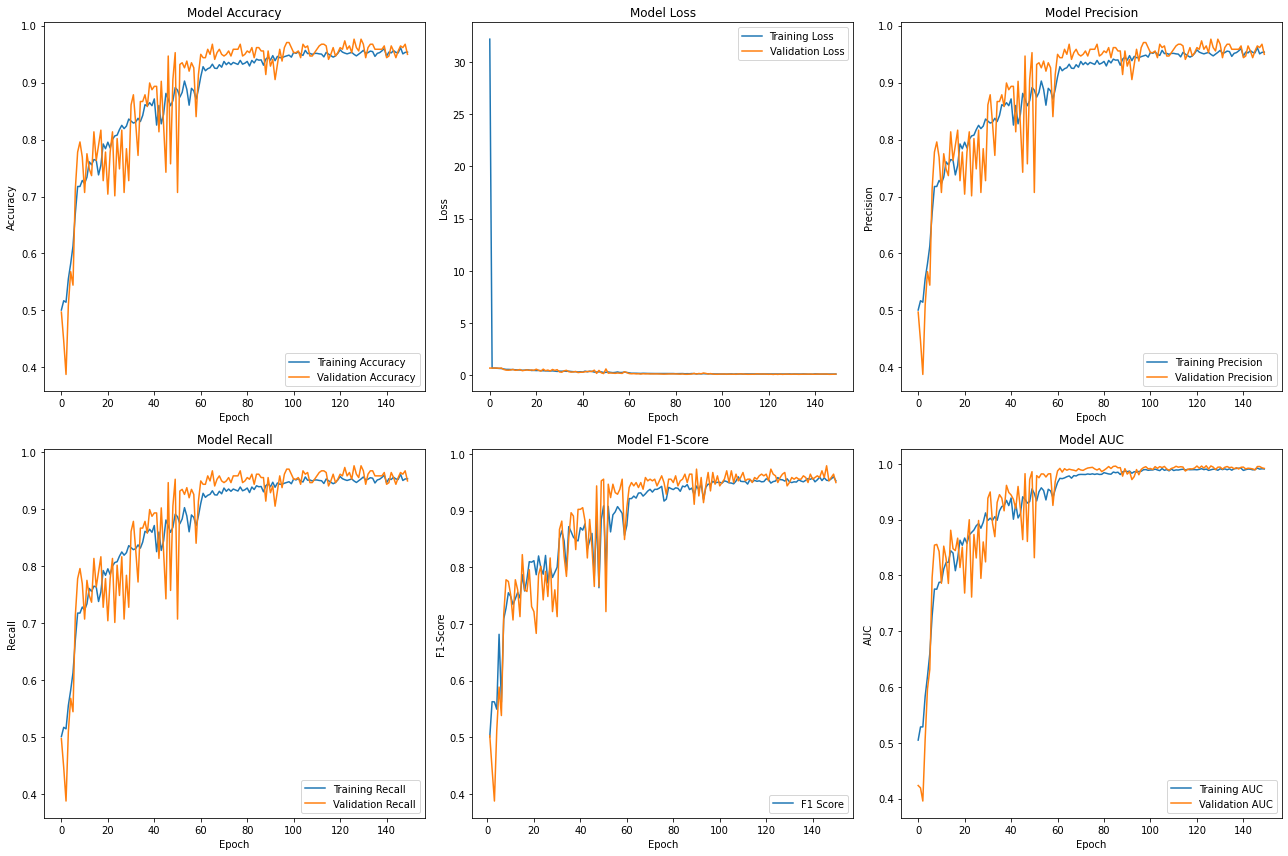

In [24]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(history.history['precision_2'])
plt.plot(history.history['val_precision_2'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training Precision', 'Validation Precision'], loc='lower right')


plt.subplot(2, 3, 4)
plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'], loc='lower right')

# plt.subplot(2, 3, 5)
# plt.plot(history.history['f1_score'])
# plt.plot(history.history['val_f1_score'])
# plt.title('Model F1-Score')
# plt.xlabel('Epoch')
# plt.ylabel('F1-Score')
# plt.legend(['Training F1-Score', 'Validation F1-Score'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(range(1, len(f1_score_callback.train_f1_scores) + 1), f1_score_callback.train_f1_scores, label='Training F1 Score')
plt.plot(range(1, len(f1_score_callback.val_f1_scores) + 1), f1_score_callback.val_f1_scores, label='Validation F1 Score')
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(['F1 Score'], loc='lower right')


plt.subplot(2, 3, 6)
plt.plot(history.history['auc_2'])
plt.plot(history.history['val_auc_2'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'], loc='lower right')

plt.tight_layout()
plt.show()

9/9 [==============================] - 1s 117ms/step


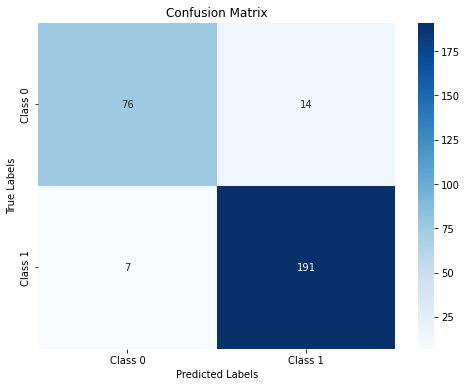

In [25]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 收集图像和真实标签
all_images, all_true_labels = zip(*[next(test_generator) for _ in range(test_generator.samples // test_generator.batch_size)])
all_images = np.concatenate(all_images)
all_true_labels = np.argmax(np.concatenate(all_true_labels), axis=1)

# 进行预测并获取预测标签
predictions = DIR.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# 生成并绘制混淆矩阵
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [26]:
from sklearn.metrics import f1_score


# 计算F1-Score
f1 = f1_score(all_true_labels, predicted_labels, average='macro')

print("F1-Score:", f1)


f1_each_class = f1_score(all_true_labels, predicted_labels, average=None)
print("F1-Score for each class:", f1_each_class)


F1-Score: 0.9132517678107832
F1-Score for each class: [0.87861272 0.94789082]


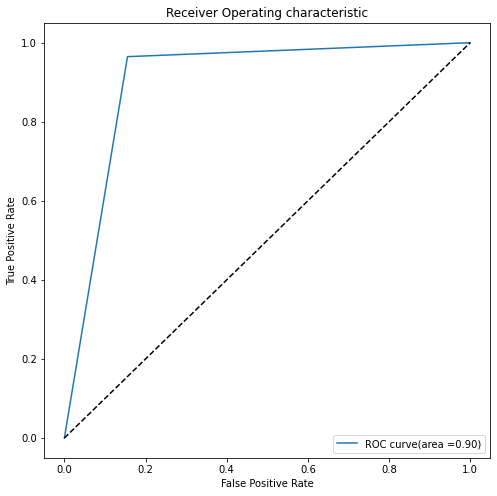

In [27]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(all_true_labels, predicted_labels)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [28]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.9646464646464646
specificity: 0.8444444444444444


9/9 [==============================] - 1s 117ms/step


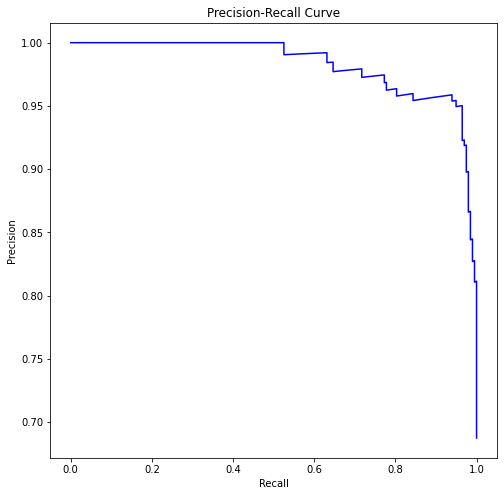

In [29]:
from sklearn.metrics import precision_recall_curve

# 计算预测概率
ensemble_pred_probs =  DIR.predict(all_images)

# 获取预测正类的概率
# 假设是二分类问题，并且正类是第二个类别
positive_class_probs = ensemble_pred_probs[:, 1]

# 计算 Precision 和 Recall
precision, recall, thresholds = precision_recall_curve(all_true_labels, positive_class_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [30]:
# test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = DIR.evaluate(test_generator)
# print('Test loss:', test_loss)
# print('Test accuracy:', test_acc)
# print('Test precision:', test_precision)
# print('Test recall:', test_recall)
# print('Test AUC:', test_auc)
# print('Test F1 Score:', test_f1_score)

test_loss, test_acc, test_precision, test_recall, test_auc = DIR.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)


from sklearn.metrics import f1_score
import numpy as np

# 预测测试集
y_pred = DIR.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# 真实标签
y_true = test_generator.classes

# 计算F1分数
test_f1_score = f1_score(y_true, y_pred, average='micro')  # 或者根据你的需要选择其他average参数
print('Test F1 Score:', test_f1_score)


10/10 [==============================] - 2s 162ms/step - loss: 0.2339 - accuracy: 0.9269 - precision_2: 0.9269 - recall_2: 0.9269 - auc_2: 0.9674
Test loss: 0.23393774032592773
Test accuracy: 0.9269102811813354
Test precision: 0.9269102811813354
Test recall: 0.9269102811813354
Test AUC: 0.9673790335655212
10/10 [==============================] - 3s 124ms/step
Test F1 Score: 0.5946843853820598


In [31]:
from sklearn.metrics import classification_report

# 使用模型对验证集进行预测，获取预测概率
y_pred_probs = DIR.predict(all_images)

# 将预测概率转换为类别标签
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 假设 y_val 是真实标签，并且也是类别标签形式
# 现在您可以生成分类报告
report = classification_report(all_true_labels, y_pred_labels)
print(report)


9/9 [==============================] - 1s 118ms/step
              precision    recall  f1-score   support

           0       0.92      0.84      0.88        90
           1       0.93      0.96      0.95       198

    accuracy                           0.93       288
   macro avg       0.92      0.90      0.91       288
weighted avg       0.93      0.93      0.93       288



In [32]:
#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

# del DIR


from numba import cuda

cuda.select_device(0)
cuda.close()